#  data loader camus PyTorch

In [1]:
from torchvision import transforms
import torchvision
import cv2
import skimage.io as io
from PIL import Image
import torch
from torch import nn
import os
from datetime import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import json
from glob import glob

In [2]:
RANDOM_SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

In [3]:
with open('configs/ventricle.json') as f:
    config = json.load(f)

In [4]:
config['NAME']

'ventricle'

In [5]:
!ls ../../datasets/CAMUS/training/patient0001

Info_2CH.cfg		      patient0001_2CH_sequence.raw
Info_4CH.cfg		      patient0001_4CH_ED_gt.mhd
patient0001_2CH_ED_gt.mhd     patient0001_4CH_ED_gt.raw
patient0001_2CH_ED_gt.raw     patient0001_4CH_ED.mhd
patient0001_2CH_ED.mhd	      patient0001_4CH_ED.raw
patient0001_2CH_ED.raw	      patient0001_4CH_ES_gt.mhd
patient0001_2CH_ES_gt.mhd     patient0001_4CH_ES_gt.raw
patient0001_2CH_ES_gt.raw     patient0001_4CH_ES.mhd
patient0001_2CH_ES.mhd	      patient0001_4CH_ES.raw
patient0001_2CH_ES.raw	      patient0001_4CH_sequence.mhd
patient0001_2CH_sequence.mhd  patient0001_4CH_sequence.raw


In [6]:
class Dataset(Dataset):
    def __init__(self, dataset_path, input_name, target_name, condition_name,
                 img_res, target_rescale, input_rescale, condition_rescale, 
                 train_ratio, valid_ratio, labels, augment, subset='train'):

        self.dataset_path = dataset_path
        self.img_res = tuple(img_res)
        self.target_rescale = target_rescale
        self.input_rescale = input_rescale
        self.condition_rescale = condition_rescale
        self.input_name = input_name
        self.target_name = target_name
        self.condition_name = condition_name
        self.augment = augment
        self.items = []
    
        patients = sorted(glob(os.path.join(self.dataset_path, 'training', '*')))
        
        for patient in patients:
            path = patient
            head, patient_id = os.path.split(path)
            target_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.target_name))
            condition_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.condition_name))
            input_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.input_name))
            self.items.append((target_path, condition_path, input_path))

        
        random.Random().shuffle(self.items)
        num = len(self.items)

        all_labels = {0, 1, 2, 3}
        self.not_labels = all_labels - set(labels)

        if subset == 'train':
            self.items = self.items[: int(train_ratio * num)]
        elif subset == 'valid':
            self.items = self.items[int(train_ratio * num): int(train_ratio * num) + int(valid_ratio * num)]
        elif subset == 'test':
            self.items = self.items[int(train_ratio * num) + int(valid_ratio * num):]
        
    def get_patient_data(self, paths, stage): # _get_batch
        target_imgs = []
        input_imgs = []
        condition_imgs = []
        weight_maps = []
        
        for path in paths_batch:

            head, patient_id = os.path.split(path)
            target_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.target_name))
            condition_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.condition_name))
            input_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.input_name))
            
            input_img = self.read_mhd(input_path, '_gt' in self.input_name)
            
            input_imgs.append(input_img)

            target_img = self.read_mhd(target_path, '_gt' in self.target_name)
            condition_img = self.read_mhd(condition_path, 1)

            
            target_imgs.append(target_img)
            condition_imgs.append(condition_img)

            weight_map_condition = self.get_weight_map(condition_img)
            weight_maps.append(weight_map_condition)

        return np.array(target_imgs), np.array(condition_imgs), np.array(input_imgs), np.array(weight_maps)
    
    def read_mhd(self, img_path, is_gt):
        if not os.path.exists(img_path):
            return np.zeros(self.img_res + (1,))
        img = io.imread(img_path, plugin='simpleitk').squeeze()

        img = np.array(Image.fromarray(img).resize(self.img_res))

        if is_gt:
            for not_l in self.not_labels:
                img[img == not_l] = 0
        return img
    
    def get_weight_map(self, mask):
        # let the y axis have higher variance
        gauss_var = [[self.img_res[0] * 60, 0], [0, self.img_res[1] * 30]]

        x, y = mask.nonzero()

        center = [x.mean(), y.mean()]


        from scipy.stats import multivariate_normal
        gauss = multivariate_normal.pdf(np.mgrid[
                                        0:self.img_res[1],
                                        0:self.img_res[0]].reshape(2, -1).transpose(),
                                        mean=center,
                                        cov=gauss_var)

        gauss /= gauss.max()
        gauss = gauss.reshape((self.img_res[1], self.img_res[0]))


        # set the gauss value of the main target part to 1
        gauss[mask > 0] = 1


        return gauss
    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        target_path, condition_path, input_path = self.items[index]
        
        target = self.read_mhd(img_path = target_path, is_gt = True)#.astype(float)
        condition = self.read_mhd(img_path = condition_path, is_gt = True)
        input_ = self.read_mhd(img_path = input_path, is_gt = False)

        
        weight_map_condition = self.get_weight_map(condition)#.astype(float)
        weight_map_condition = transforms.ToTensor()(weight_map_condition)
        
        input_ = torch.tensor(np.asarray(input_)).long().unsqueeze(dim=0)
        condition = torch.tensor(np.asarray(condition)).long().unsqueeze(dim=0)
        
        target = transforms.ToTensor()(target)
        
        return target, condition, input_, weight_map_condition


In [7]:
augmentation = dict()
for key, value in config.items():
    if 'AUG_' in key:
        augmentation[key] = value

In [8]:
augmentation

{'AUG_TARGET': False,
 'AUG_INPUT': False,
 'AUG_ROTATION_RANGE_DEGREES': 0,
 'AUG_WIDTH_SHIFT_RANGE_RATIO': 0.0,
 'AUG_HEIGHT_SHIFT_RANGE_RATIO': 0.0,
 'AUG_SHEAR_RANGE_ANGLE': 0,
 'AUG_ZOOM_RANGE_RATIO': 0.0}

In [9]:
train_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='test')

In [10]:
train_data.__len__()

15

In [11]:
target, condition, input_, weight_map_condition = train_data[0]

In [12]:
print(target.shape)
print(condition.shape)
print(input_.shape)
print(weight_map_condition.shape)

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


In [13]:
print(target.dtype)
print(condition.dtype)
print(input_.dtype)
print(weight_map_condition.dtype)

torch.float32
torch.int64
torch.int64
torch.float64


In [14]:
print(target.min(), target.max())
print(condition.min(), condition.max())
print(input_.min(), input_.max())
print(weight_map_condition.min(), weight_map_condition.max())

tensor(0.) tensor(1.)
tensor(0) tensor(1)
tensor(0) tensor(3)
tensor(0.1499, dtype=torch.float64) tensor(1., dtype=torch.float64)


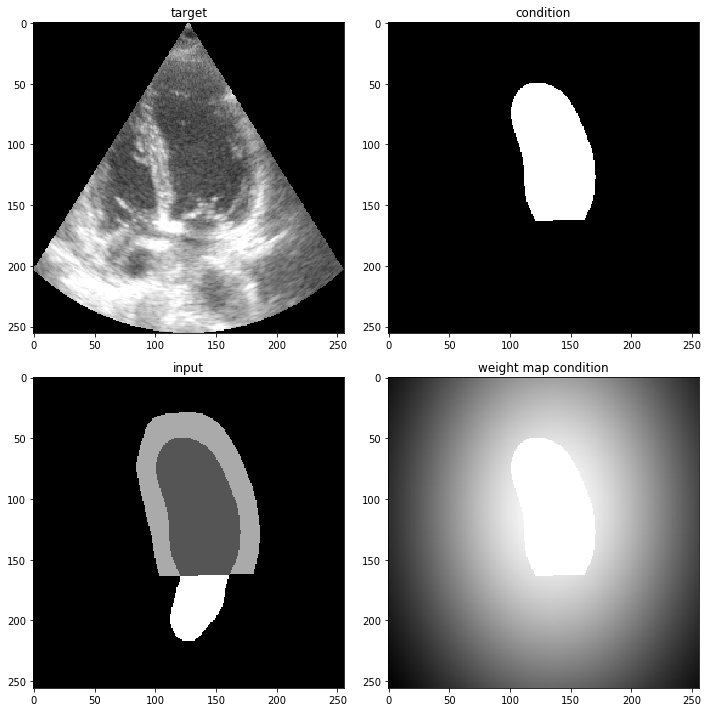

In [16]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('target')
plt.imshow(target[0], cmap='gray')

plt.subplot(2, 2, 2)
plt.title('condition')
plt.imshow(condition[0], cmap='gray')

plt.subplot(2, 2, 3)
plt.title('input')
plt.imshow(input_[0], cmap='gray')

plt.subplot(2, 2, 4)
plt.title('weight map condition')
plt.imshow(weight_map_condition[0], cmap='gray')
plt.tight_layout()

In [17]:
train_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='train')
valid_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='valid')
test_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='test')

In [18]:
train_data.__len__(), valid_data.__len__(), test_data.__len__()

(475, 10, 15)

In [19]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=32, 
                                           shuffle=True,
                                           num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=8, 
                                           shuffle=False,
                                           num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=8, 
                                          shuffle=False,
                                          num_workers=4)

In [20]:
targets, conditions, inputs, weight_maps_conditions = next(iter(valid_loader))

In [21]:
targets.shape, conditions.shape, inputs.shape, weight_maps_conditions.shape

(torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]))

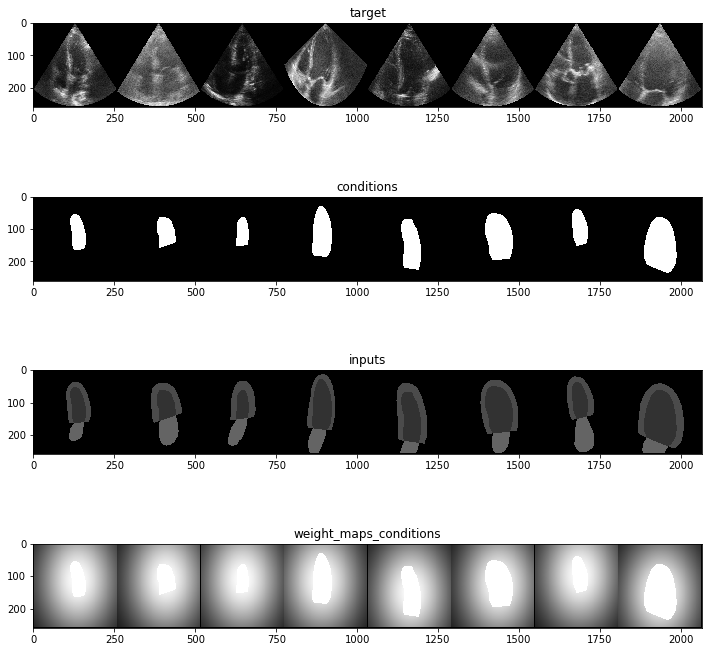

In [22]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.title('target')
plt.imshow(torchvision.utils.make_grid(targets).numpy().transpose(1,2,0))

plt.subplot(4, 1, 2)
plt.title('conditions')
plt.imshow(torchvision.utils.make_grid(conditions).float().numpy().transpose(1,2,0))

plt.subplot(4, 1, 3)
plt.title('inputs')
inputs[inputs == 1] = 50
inputs[inputs == 2] = 75
inputs[inputs == 3] = 100
plt.imshow(torchvision.utils.make_grid(inputs).numpy().transpose(1,2,0))

plt.subplot(4, 1, 4)
plt.title('weight_maps_conditions')
plt.imshow(torchvision.utils.make_grid(weight_maps_conditions).numpy().transpose(1,2,0));
plt.tight_layout()